In [1]:
import random, time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

%matplotlib inline

# Load MNIST Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))
                               ])
train_dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='.', train=False, transform=transform, download=True)

print(train_dataset.data.shape, train_dataset.targets.shape, val_dataset.data.shape, val_dataset.targets.shape)

torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [3]:
# create dataloader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=False)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False, drop_last=False)

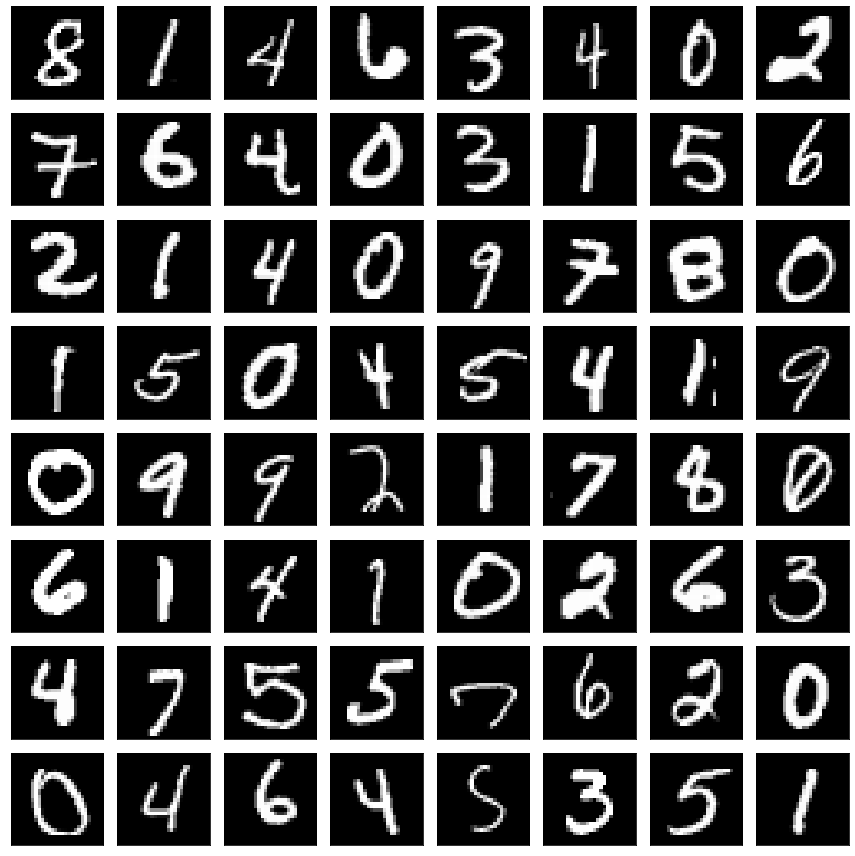

In [4]:
# visualize sample images
for x, y in train_dataloader:
    break
    
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(x[i * 8 + j][0], cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.tight_layout()
plt.show()

# Build MLP Network

In [5]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        
        return x
    
model = MyMLP()
print(model)

MyMLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


# Train Neural Network

In [6]:
# define criterion and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [7]:
# train neural network
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

num_epochs = 50

for i in range(num_epochs):
    t0 = time.time()
    train_loss = 0
    train_correct = 0
    train_cnt = 0
    val_loss = 0
    val_correct = 0
    val_cnt = 0
    
    # training steps
    model.train()
    for batch_x, batch_y in train_dataloader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        train_loss += loss.item() * batch_x.shape[0]
        train_correct += (torch.argmax(output, dim=1) == batch_y).sum().item()
        train_cnt += batch_x.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # validation steps
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            output = model(batch_x)
            loss = criterion(output, batch_y)
            
            val_loss += loss.item() * batch_x.shape[0]
            val_correct += (torch.argmax(output, dim=1) == batch_y).sum().item()
            val_cnt += batch_x.shape[0]
            
    # get epoch statistics
    train_epoch_loss = train_loss / train_cnt
    train_epoch_acc = train_correct / train_cnt
    val_epoch_loss = val_loss / val_cnt
    val_epoch_acc = val_correct / val_cnt
    
    train_loss_list.append(train_epoch_loss)
    train_acc_list.append(train_epoch_acc)
    val_loss_list.append(val_epoch_loss)
    val_acc_list.append(val_epoch_acc)
    
    # print helpful information
    elapsed_time = time.time() - t0
    prefix = 'Epoch {:3} ==> train_loss:{:7.4f}  train_acc:{:7.4f}  val_loss:{:7.4f}  val_acc:{:7.4f}  time: {:3.0f}s'
    print(prefix.format(i+1, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc, elapsed_time))

Epoch   1 ==> train_loss: 0.4614  train_acc: 0.8602  val_loss: 0.2301  val_acc: 0.9358  time:  14s
Epoch   2 ==> train_loss: 0.3256  train_acc: 0.9044  val_loss: 0.1654  val_acc: 0.9513  time:  16s
Epoch   3 ==> train_loss: 0.2943  train_acc: 0.9127  val_loss: 0.1448  val_acc: 0.9581  time:  18s
Epoch   4 ==> train_loss: 0.2615  train_acc: 0.9237  val_loss: 0.1464  val_acc: 0.9585  time:  17s
Epoch   5 ==> train_loss: 0.2465  train_acc: 0.9275  val_loss: 0.1415  val_acc: 0.9636  time:  18s
Epoch   6 ==> train_loss: 0.2305  train_acc: 0.9324  val_loss: 0.1132  val_acc: 0.9659  time:  17s
Epoch   7 ==> train_loss: 0.2202  train_acc: 0.9349  val_loss: 0.1130  val_acc: 0.9678  time:  19s
Epoch   8 ==> train_loss: 0.2141  train_acc: 0.9381  val_loss: 0.1247  val_acc: 0.9633  time:  19s
Epoch   9 ==> train_loss: 0.2065  train_acc: 0.9397  val_loss: 0.1512  val_acc: 0.9673  time:  17s
Epoch  10 ==> train_loss: 0.1969  train_acc: 0.9422  val_loss: 0.1462  val_acc: 0.9682  time:  17s
Epoch  11 

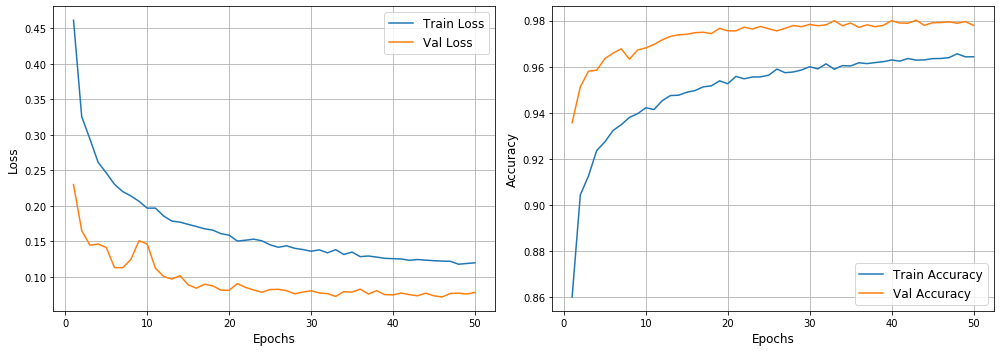

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axs[0].plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
axs[0].plot(range(1, num_epochs + 1), val_loss_list, label='Val Loss')
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True)
axs[1].plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
axs[1].plot(range(1, num_epochs + 1), val_acc_list, label='Val Accuracy')
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True)
plt.tight_layout()
plt.show()